In [1]:
import sys
import os
import glob
import numpy as np
import cv2
import scipy.misc
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
# from google.colab import files

%matplotlib inline

Image shape is: (512, 512)


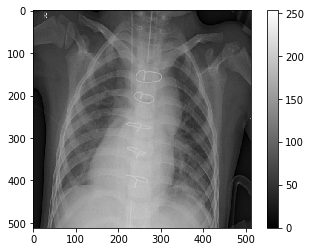

In [15]:
input_dir = 'C:/Users/AALY/copd_detection/test-pneumonia.jpeg'
#basename = 'JPCLN001.png'
filename = input_dir #+ basename
dim = (512, 512)
img = cv2.imread(filename,0) 
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
print('Image shape is:', img.shape)
plt.imshow(img,cmap='gray')
plt.colorbar()

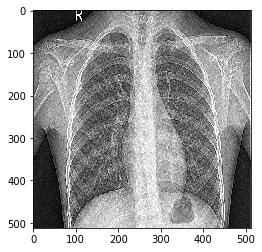

In [3]:
import cv2
import numpy as np

# Create our shapening kernel, it must equal to one eventually
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1, 9,-1],
                              [-1,-1,-1]])
# applying the sharpening kernel to the input image & displaying it.
img = cv2.filter2D(img, -1, kernel_sharpening)
# cv2.imshow('Image Sharpening', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.imshow(img,cmap='gray')

In [3]:
def eraseMax(img,eraseLineCenter=0,eraseLineWidth=40,draw=False):
    sumpix0=np.sum(img,0)
    if draw:
        plt.plot(sumpix0)
        plt.title('Sum along axis=0')
        plt.xlabel('Column number')
        plt.ylabel('Sum of column')
    max_r2=np.int_(len(sumpix0)/3)+np.argmax(sumpix0[np.int_(len(sumpix0)/3):np.int_(len(sumpix0)*2/3)])
    cv2.line(img,(max_r2+eraseLineCenter,0),(max_r2+eraseLineCenter,512),0,eraseLineWidth)
    return img

# img_erased = eraseMax(img,draw=True)

In [4]:
plt.imshow(img_erased,cmap='gray')
plt.colorbar()

NameError: name 'img_erased' is not defined

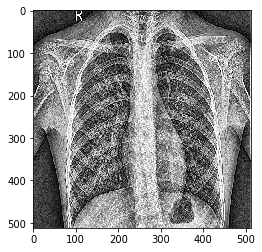

In [5]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img)   
plt.imshow(img_clahe,cmap='gray')

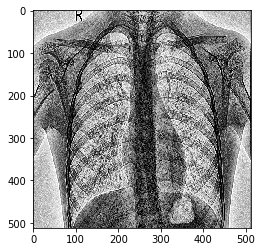

In [6]:
ker = 169
kernel = np.ones((ker,ker),np.uint8)
blackhat = cv2.morphologyEx(img_clahe, cv2.MORPH_BLACKHAT, kernel)    
plt.imshow(blackhat,cmap='gray')

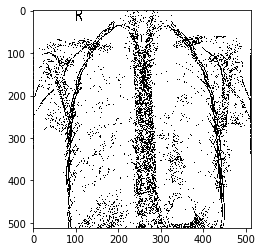

In [7]:
threshold = 45
ret, thresh = cv2.threshold(blackhat, threshold, 255, 0)
plt.imshow(thresh,cmap='gray')

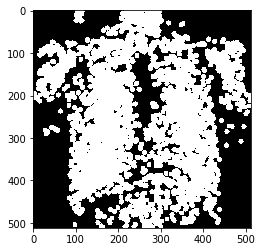

In [10]:
def get_cmask(img, maxCorners=3800, qualityLevel=0.001, minDistance=1,Cradius=6):
    corners = cv2.goodFeaturesToTrack(img, maxCorners, qualityLevel, minDistance)
    corners = np.int0(corners)
    cmask = np.zeros(img.shape)
    for corner in corners:
        x,y = corner.ravel()
        cv2.circle(cmask,(x,y),Cradius,1,-1)
    return cmask

cmask = get_cmask(img_clahe)
plt.imshow(cmask,cmap='gray')

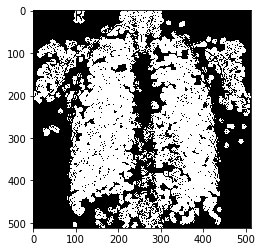

In [11]:
mask = np.multiply(cmask,thresh).astype('uint8')
plt.imshow(mask,cmap='gray')

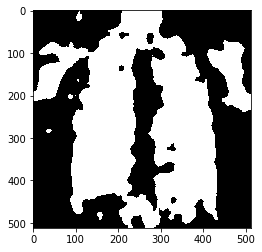

In [12]:
median = cv2.medianBlur(mask,23) 
plt.imshow(median,cmap='gray')

True

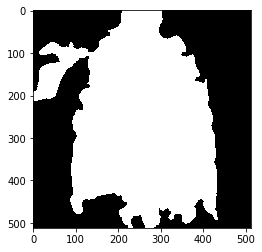

In [14]:
def contourMask(image):
    contours,hierc = cv2.findContours(image,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 
    area = np.zeros(len(contours))
    for j in range(len(contours)):
        cnt = contours[j]
        area[j] = cv2.contourArea(cnt)
    mask = np.zeros(image.shape)
    cv2.drawContours(mask, contours, np.argmax(area), (255), -1)#draw largest contour-usually right lung   
    temp = np.copy(area[np.argmax(area)])
    area[np.argmax(area)]=0
    if area[np.argmax(area)] > temp/10:#make sure 2nd largest contour is also lung, not 2 lungs connected
        cv2.drawContours(mask, contours, np.argmax(area), (255), -1)#draw second largest contour  
    contours.clear() 
    return mask

contour_mask = contourMask(median).astype('uint8')
plt.imshow(contour_mask,cmap='gray')
cv2.imwrite("mask_new.jpeg", contour_mask) 

In [17]:
newimg = apply_mask('C:/Users/AALY/copd_detection/normal-img.jpeg' , 'C:/Users/AALY/copd_detection/mask_new.jpeg')
newimg.save("new_segment_appliedmask.jpeg")

C:/Users/AALY/copd_detection/normal-img.jpeg


In [100]:
img = cv2.imread("C:/Users/AALY/copd_detection/chest_xray/train/PNEUMONIA/person1008_virus_1691.jpeg")
img.shape

(1328, 1576, 3)

In [98]:
img = cv2.imread("C:/Users/AALY/copd_detection/chest_xray/train/PNEUMONIA/person1010_virus_1695.jpeg")
img.shape

(307, 502, 3)

In [16]:
import numpy as np
from PIL import Image
input_dir = "C:/Users/AALY/copd_detection/sir_given_val/normal/"
pre_dir = "C:/Users/AALY/copd_detection/sir_given_val/pre-normal/"
def apply_mask(img_path, mask_path):
    
    src = np.array(Image.open(img_path))
    dim = src.shape
    mask = np.array(Image.open(mask_path).resize(src.shape[1::-1], Image.BILINEAR))
    print(img_path)


    mask = mask / 255
    if len(dim) == 3:
        mask = mask[:, :, np.newaxis]


    dst = src * mask

    # plt.imshow(dst,cmap='gray')
    return Image.fromarray(dst.astype(np.uint8))

# pre_count = 1
# for filename in glob.glob(os.path.join(input_dir, '*.jpeg')):

# #     basename = os.path.basename(filename)

#         #GTmask = cv2.imread(GTmask_dir+basename,0) 
#     get_mask_dir = "C:/Users/AALY/copd_detection/sir_given_val/mask-normal/"+ "sir-val-normal-" +str(pre_count)+ ".jpeg"
#     masked_img = apply_mask(filename, get_mask_dir)
#     write_dir = pre_dir + "sir-val-normal-" + str(pre_count) + ".jpeg"
#     masked_img.save(write_dir)    
#     print(pre_count)
#     pre_count = pre_count + 1

In [14]:
src = np.array(Image.open("C:/Users/AALY/copd_detection/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg"))
print(src.shape)
dim = src.shape
mask = np.array(Image.open("C:/Users/AALY/copd_detection/image-masks/train/pneumonia/mask-train-pneumonia-18.jpeg").resize(src.shape[1::-1], Image.BILINEAR))
print(mask.shape)
mask = mask / 255

print(mask.shape)
# mask = mask.reshape(*mask.shape, 1)
dst = src * mask



img=Image.fromarray(dst.astype(np.uint8))
img.size

(760, 1152)
(760, 1152)
(760, 1152)


(1152, 760)

In [15]:
len(dim)

2

In [27]:
input_dir = "C:/Users/AALY/copd_detection/sir_given_val/normal/"
mask_dir = "C:/Users/AALY/copd_detection/sir_given_val/mask-normal/"
dim = (512, 512)
def seg(filename, blackHatKernel=169,threshold=45,medianKernel=23,maxCorners=3800,Cradius=6,clipLimit=2.0,
        tileGridSize=(8,8),eraseLineCenter=0):
    img = cv2.imread(filename,0) 
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    rows,cols = img.shape
    # Create our shapening kernel, it must equal to one eventually
    kernel_sharpening = np.array([[-1,-1,-1], 
                                  [-1, 9,-1],
                                  [-1,-1,-1]])
    # applying the sharpening kernel to the input image & displaying it.
    img = cv2.filter2D(img, -1, kernel_sharpening)    

    img = eraseMax(img,eraseLineCenter)

    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    img = clahe.apply(img)    

    ker = blackHatKernel
    kernel = np.ones((ker,ker),np.uint8)
    blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel) 

    ret, thresh = cv2.threshold(blackhat, threshold, 255, 0)

    cmask = get_cmask(img,maxCorners,Cradius=Cradius)

    mask = np.multiply(cmask,thresh).astype('uint8')

    median = cv2.medianBlur(mask,medianKernel) 

    contour_mask = contourMask(median)   

    return contour_mask.astype('uint8')

#Jvec = []
mask_count = 1
for filename in glob.glob(os.path.join(input_dir, '*.jpeg')):

#     basename = os.path.basename(filename)

    #GTmask = cv2.imread(GTmask_dir+basename,0) 

    mask = seg(filename)
    write_dir = mask_dir + "sir-val-normal-" + str(mask_count) + ".jpeg"
    cv2.imwrite(write_dir, mask)    
    print(mask_count)
    mask_count = mask_count + 1
    
    #J = Jaccard(mask,GTmask)

    #Jvec.append(J)

# Javg = np.mean(Jvec)
# print(f'Average Jaccard index over all 246 images is {Javg}')

1


In [47]:
import numpy as np
import cv2, matplotlib.pyplot as plt
%matplotlib inline

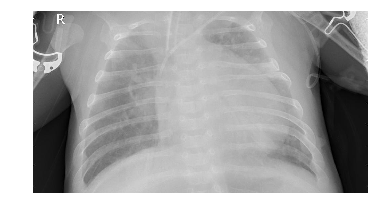

In [48]:
img = cv2.imread('C:/Users/AALY/copd_detection/testsegment.jpeg') # in BGR mode
# convert to RGB mode
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis('off')
plt.imshow(img)

In [49]:
import cv2
import numpy as np

# Create our shapening kernel, it must equal to one eventually
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1, 9,-1],
                              [-1,-1,-1]])
# applying the sharpening kernel to the input image & displaying it.
img = cv2.filter2D(img, -1, kernel_sharpening)
cv2.imshow('Image Sharpening', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Threshold limit: 108.0


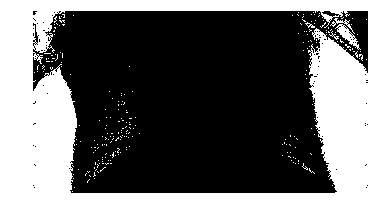

In [50]:
# performing otsu's binarization
# convert to gray scale first
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
print("Threshold limit: " + str(ret))

plt.axis('off')
plt.imshow(thresh, cmap = 'gray')

In [51]:
# noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations = 3)

# sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

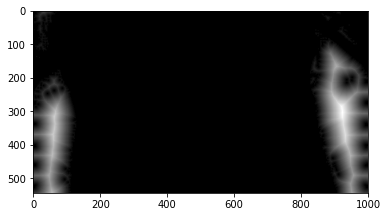

In [52]:

plt.imshow(dist_transform, cmap = 'gray')

In [1]:
print("hello")

hello


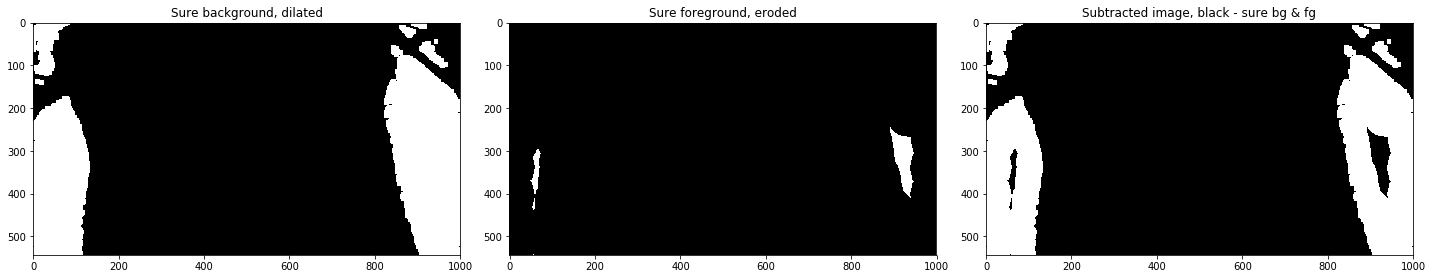

In [53]:
fig = plt.figure(figsize = (20, 10)) # to change figsize
plt.subplot(131)
plt.imshow(sure_bg, cmap = 'gray')
plt.title('Sure background, dilated')

plt.subplot(132)
plt.imshow(sure_fg, cmap = 'gray')
plt.title('Sure foreground, eroded')

plt.subplot(133)
plt.imshow(unknown, cmap = 'gray')
plt.title('Subtracted image, black - sure bg & fg')
plt.tight_layout()


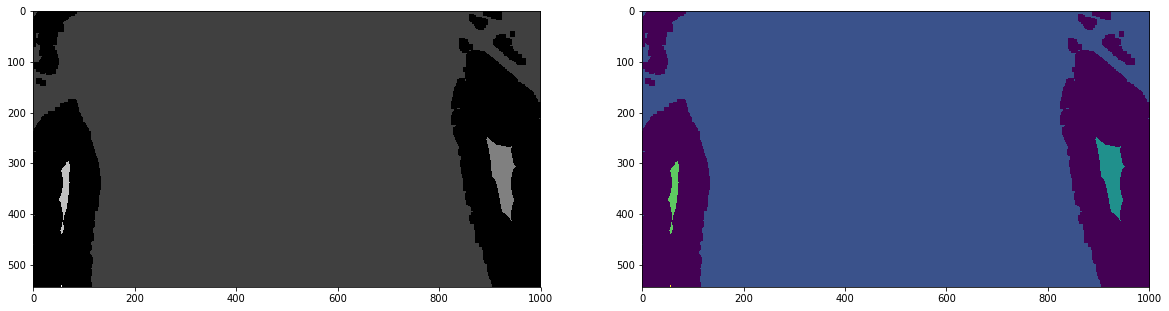

In [54]:
ret, markers = cv2.connectedComponents(sure_fg)

markers = markers + 1

markers[unknown==255] = 0

fig = plt.figure(figsize = (20, 10)) # to change figsize
plt.subplot(121)
plt.imshow(markers, cmap = 'gray')
plt.subplot(122)
plt.imshow(markers)

In [55]:

markers = cv2.watershed(img, markers)
img[markers == -1] = [0, 255,0]

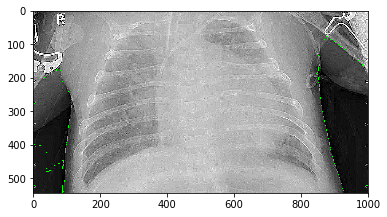

In [56]:
plt.imshow(img)

In [57]:
import cv2
import numpy as np
# Reading in and displaying our image
image = cv2.imread('C:/Users/AALY/copd_detection/testsegment.jpeg')
cv2.imshow('Original', image)
# Create our shapening kernel, it must equal to one eventually
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1, 9,-1],
                              [-1,-1,-1]])
# applying the sharpening kernel to the input image & displaying it.
sharpened = cv2.filter2D(image, -1, kernel_sharpening)
cv2.imshow('Image Sharpening', sharpened)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [2]:
import cv2
img = cv2.imread('C:/Users/AALY/copd_detection/test-pneumonia.jpeg',0)  #pass 0 to convert into gray level 
dim = (512,512)
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
ret,thr = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
cv2.imshow('win1', thr)
cv2.waitKey(0)  
cv2.destroyAllWindows()

In [ ]:
hello

In [16]:
import numpy as np
import cv2

img = cv2.imread('C:/Users/AALY/copd_detection/test-pneumonia.jpeg')
dim = (300,300)
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
Z = img.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

cv2.imshow('res2',res2)
cv2.waitKey(0)
cv2.destroyAllWindows()

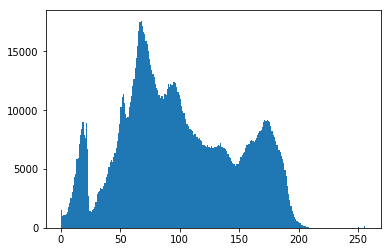

In [12]:
import cv2 
from matplotlib import pyplot as plt 
img = cv2.imread('C:/Users/AALY/copd_detection/test-pneumonia.jpeg',0) 
# To specify the number of ticks on both or any single axes
plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=10)
# alternative way to find histogram of an image 
plt.hist(img.ravel(),256,[0,256]) 
plt.savefig('histogram.jpeg')
plt.show() 